# Data insights

## Introduction

### This dataset consists of the following data:

- Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.  
- Failure history: The failure history of a machine or component within the machine.  
- Maintenance history: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.  
- Machine features: The features of a machine, e.g. engine size, make and model, location.  

### Details
- Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.  

- Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.  

- Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.  

- Failures (PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.  

- Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines.  

### Acknowledgements
This dataset was available as a part of Azure AI Notebooks for Predictive Maintenance. But as of 15th Oct, 2020 the notebook (link) is no longer available. However, the data can still be downloaded using the following URLs:

https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_telemetry.csv  
https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_errors.csv  
https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_maint.csv  
https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_failures.csv  
https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_machines.csv  

### Get libraries and data

In [1]:
from utils import unzip_files
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Unzip files
input_path='data.zip'
output_path='data'
unzip_files(input_path,output_path)

## Quick glance into data

### Machine data

In [3]:
# Machine features
df_machines=pd.read_csv('data/PdM_machines.csv')
df_machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   machineID  100 non-null    int64 
 1   model      100 non-null    object
 2   age        100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [4]:
df_machines.describe()

,machineID,age
count,100.000000,100.000000
mean,50.500000,11.330000
std,29.011492,5.856974
min,1.000000,0.000000
25%,25.750000,6.750000
50%,50.500000,12.000000
75%,75.250000,16.000000
max,100.000000,20.000000


In [5]:
# check if machineID is unique
len(df_machines.machineID.unique())

100

<function matplotlib.pyplot.show(close=None, block=None)>

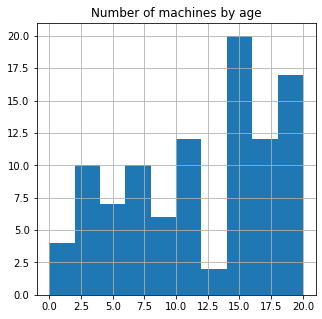

In [6]:
#Histogram: number of machines by age
df_machines.age.hist(bins=10, figsize=(5,5)).set_title('Number of machines by age')
plt.show

Text(0.5, 1.0, 'Number of machines by model')

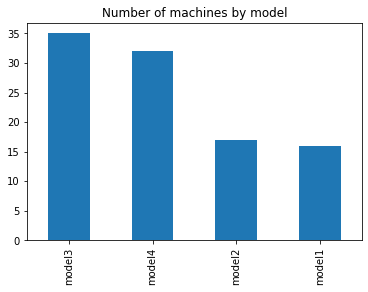

In [7]:
df_machines.model.value_counts().plot.bar().set_title('Number of machines by model')

Summary

- There are 100 machines of 4 different types (models)
- Most of the machines are of model 3 and 4
- The machines are between 0 and 20 years old
- No missing values
- All machine id's are unique

### Telemetry

In [8]:
# Telemetry
df_telemetry=pd.read_csv('data/PdM_telemetry.csv')
df_telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


In [9]:
#Last date in dataset
df_telemetry.datetime.max()

'2016-01-01 06:00:00'

In [10]:
#First date in dataset
df_telemetry.datetime.min()

'2015-01-01 06:00:00'

In [11]:
df_telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


<function matplotlib.pyplot.show(close=None, block=None)>

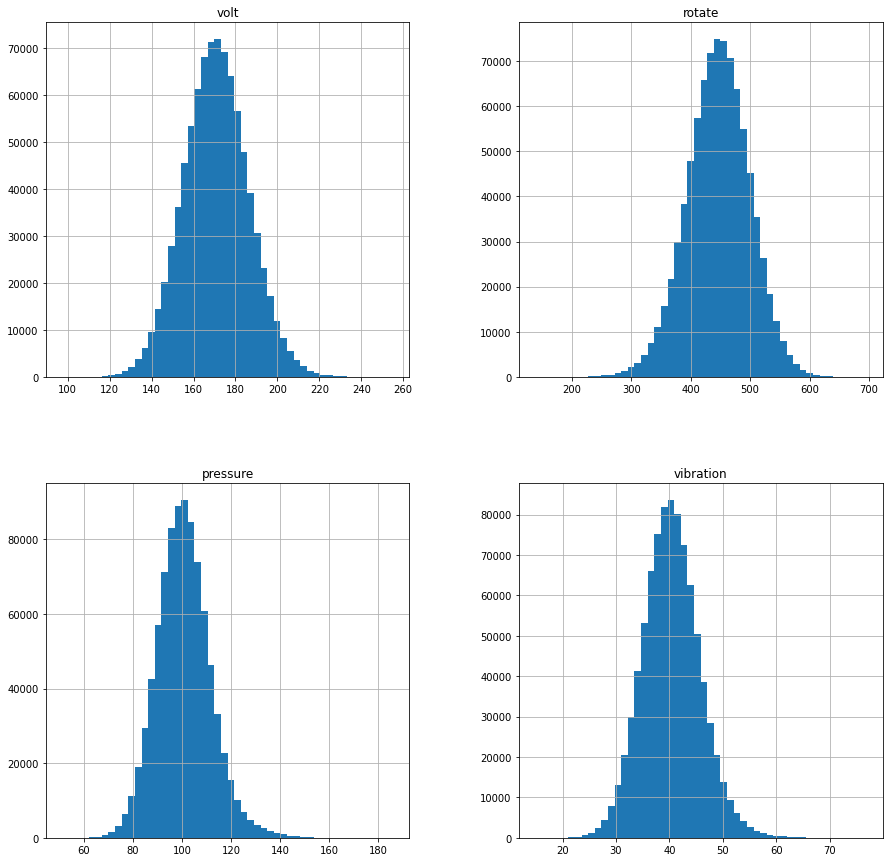

In [12]:
df_telemetry.drop('machineID',axis=1).hist(bins=50, figsize=(15,15))
plt.show

Summary

- Telemetry data of one year (2015)
- Attributes: voltage, rotation, pressure and vibration
- No missing values

### Errors

In [13]:
# Errors
df_errors=pd.read_csv('data/PdM_errors.csv')
df_errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3919 non-null   object
 1   machineID  3919 non-null   int64 
 2   errorID    3919 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.0+ KB


In [14]:
df_errors.describe()

,machineID
count,3919.000000
mean,51.044654
std,28.954988
min,1.000000
25%,25.000000
50%,51.000000
75%,77.000000
max,100.000000


Text(0.5, 1.0, 'Number of errors by error id')

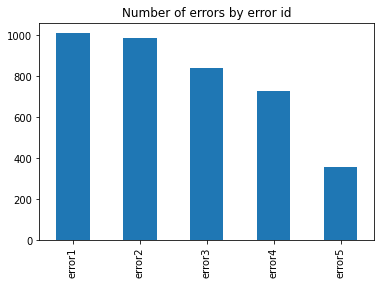

In [15]:
df_errors.errorID.value_counts().plot.bar().set_title('Number of errors by error id')

In [16]:
df_errors.datetime=pd.to_datetime(df_errors.datetime)
df_errors['date']=df_errors.datetime.dt.date
df_errors['month']=df_errors.datetime.dt.month

Text(0.5, 1.0, 'Errors per month')

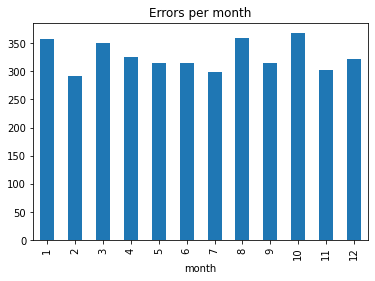

In [17]:
errors_per_month=df_errors.groupby([df_errors.month]).count()
errors_per_month.errorID.plot.bar().set_title('Errors per month')

Summary

- 5 different errors
- Errors are more or less equally divided over the year
- Attributes: voltage, rotation, pressure and vibration
- No missing values

### Failures

In [18]:
# Failures
df_failures=pd.read_csv('data/PdM_failures.csv')
df_failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   761 non-null    object
 1   machineID  761 non-null    int64 
 2   failure    761 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.0+ KB


In [19]:
df_failures.describe()

,machineID
count,761.000000
mean,51.911958
std,29.515542
min,1.000000
25%,24.000000
50%,51.000000
75%,79.000000
max,100.000000


Text(0.5, 1.0, 'Number of failures by component')

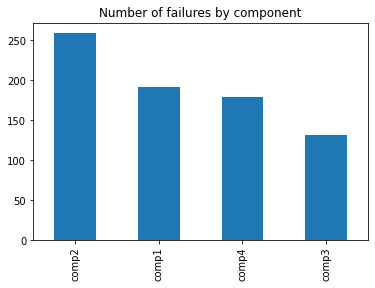

In [20]:
df_failures.failure.value_counts().plot.bar().set_title('Number of failures by component')

In [21]:
df_failures.datetime=pd.to_datetime(df_errors.datetime)
df_failures['date']=df_errors.datetime.dt.date
df_failures['month']=df_errors.datetime.dt.month

Text(0.5, 1.0, 'Number of failures per month')

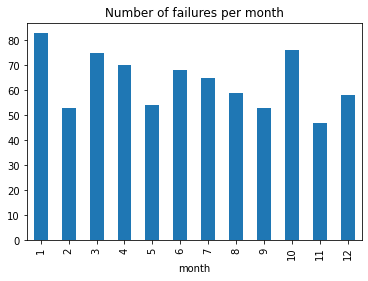

In [22]:
failure_per_month=df_failures.groupby([df_failures.month]).count()
failure_per_month.failure.plot.bar().set_title('Number of failures per month')

Summary

- 4 different different components failed certain times
- No missing values

### Maintenance

In [23]:
# Maintenance
df_maint=pd.read_csv('data/PdM_maint.csv')
df_maint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3286 non-null   object
 1   machineID  3286 non-null   int64 
 2   comp       3286 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


In [24]:
df_maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [25]:
df_maint.datetime.min()

'2014-06-01 06:00:00'

In [26]:
df_maint.datetime.max()

'2016-01-01 06:00:00'

In [27]:
df_maint.datetime=pd.to_datetime(df_maint.datetime)
df_maint['date']=df_maint.datetime.dt.date
df_maint['month']=df_maint.datetime.dt.month

In [28]:
#types of maintenance
df_maint.comp.value_counts()

comp2    863
comp4    811
comp3    808
comp1    804
Name: comp, dtype: int64

Text(0.5, 1.0, 'Maintenance per month (total)')

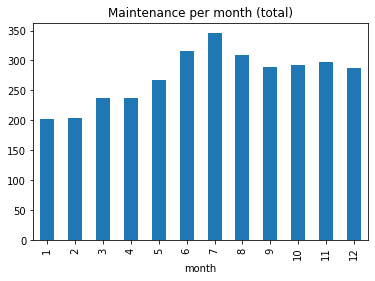

In [29]:
maint_per_month=df_maint.groupby([df_maint.month]).count()
maint_per_month.comp.plot(kind='bar', stacked='true').set_title('Maintenance per month (total)')

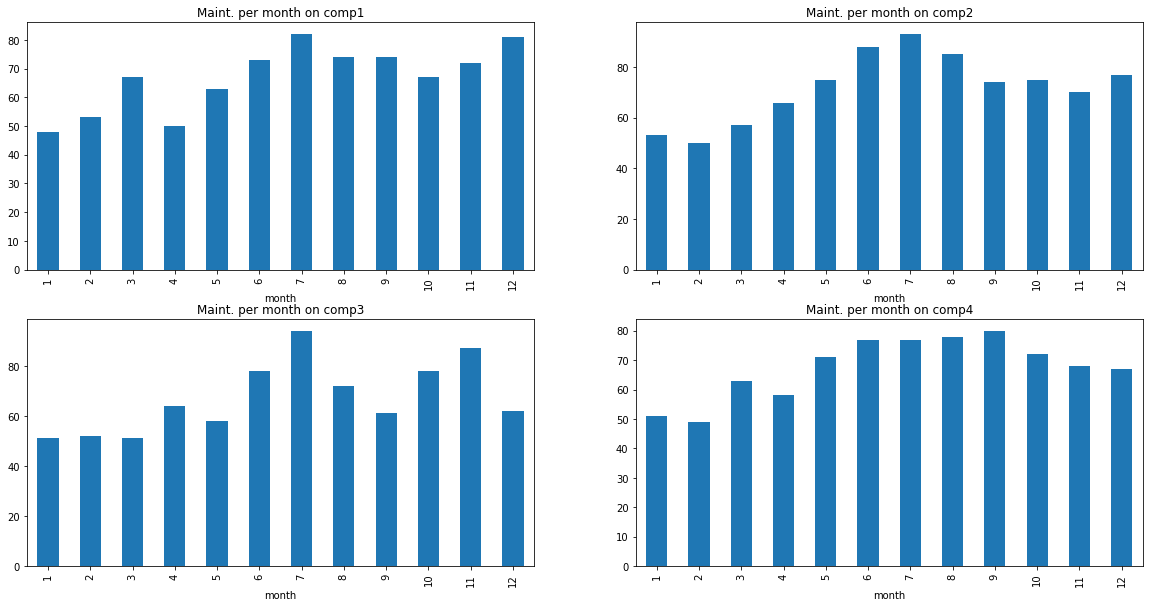

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2)

ax_coord=[[0,0],[0,1],[1,0],[1,1]]

i=0
for c in df_maint.sort_values(by=['comp']).comp.unique():
    maint_c=df_maint[df_maint.comp==c]
    maint_c_per_month=maint_c.groupby([maint_c.month]).count()
    maint_c_per_month.comp.plot(kind='bar', stacked='true', figsize=(20,10), ax=axes[ax_coord[i][0],ax_coord[i][1]]).set_title('Maint. per month on '+c)
    i+=1
    
plt.show()

Summary
- Maintenance data of 2 years
- No missing values

# Visualization of combined data

In [ ]:
#filter data for one machine
#join telemetry data with failures and errors to find correlations